In [3]:
import numpy as np
import cv2 as cv
from skimage.measure import compare_psnr

In [4]:
imagePath='1.bmp'
image=cv.imread(imagePath)
image=cv.cvtColor(image,cv.COLOR_BGR2GRAY)
rows,cols=image.shape
rows,cols

(112, 92)

In [5]:
print("原始图片降维个数"+str(cols))
print(image)

原始图片降维个数92
[[126 130 131 ... 121 121 121]
 [128 127 132 ... 121 120 120]
 [129 127 131 ... 120 122 120]
 ...
 [ 47  46  48 ...  34  44  45]
 [ 48  46  44 ...  40  49  41]
 [ 52  46  48 ...  43  51  48]]


In [6]:
mdata=np.float32(np.mat(image))
#去中心化
mean=np.mean(mdata,axis=0)
mmean=np.tile(mean,(rows,1))
newdata=mdata-mmean
newdata.shape

(112, 92)

In [7]:
#找到最大k个特征向量
k=20
covdata=np.cov(newdata,rowvar=0)
D,V=np.linalg.eig(covdata)
eigenvalue=np.argsort(D)
K_eigenvalue=eigenvalue[-1:-(k+1):-1]
K_eigenvector=V[:,K_eigenvalue]

In [8]:
K_eigenvector.shape

(92, 20)

In [9]:
lowdata=newdata*K_eigenvector
lowdata.shape

(112, 20)

In [10]:
fdata=lowdata*K_eigenvector.T+mmean
fdata.shape

(112, 92)

In [11]:
pimage=np.uint8(np.mat(fdata))
cv.imshow("p",pimage)
cv.waitKey(0)

-1

In [10]:
print("信噪比",compare_psnr(image,pimage,255))

信噪比 35.323856347958646


In [12]:
from PIL import Image
import numpy as np
import math 
import scipy
import os, sys
import matplotlib.pyplot as plt
class PCA_data:
    def __init__(self):
        self.ori_data = np.array([])
        self.imag_shape = (112,92)   #每个图片的像素分布
    def Read_face(self,dict='C:\\Users\\DDM\\Desktop\\Term1\\neturalnetwork\\data\\face\\s',x=0):
        #生成包含人脸数据的矩阵
        for i in range(1,41):
            for j in range(1,11):
                temp = i 
                Dictory = dict+str(temp)+ "\\"+str(j)+".bmp"
                im = Image.open(Dictory)
                imag = np.array([np.array(im).flatten()])
                if len(self.ori_data)==0:
                    self.ori_data = imag
                else :
                    self.ori_data = np.r_[self.ori_data,imag]
                del im,imag
        return  self.ori_data
    def Imag_produce(self,cov_data,Dict='face_restoration\\'):
        #将压缩后恢复的数据还原为图像
        length = len(cov_data)
        for i in range(length):
            dictory = Dict +str(int(i/10)+1)
            os.makedirs(dictory,exist_ok=True)
            bmp_data = np.array([cov_data[i]])
            new_im = Image.fromarray(bmp_data.reshape(self.imag_shape))
            new_im.save(dictory+'\\'+str(i%10+1)+'.bmp')
        return 

    def picture_show(self,pictures,title,order = 0):
        #numb = len(pictures)                     
                            #获取图像数目
        figure = plt.figure(1)      
                            #初始化
        for i in range(80):
            img = pictures[i*5+order].reshape(self.imag_shape)
                                        #图像还原
            plt.subplot(8,10,i+1)
            #vmax = max(pictures[i].max(), -pictures[i].min())                            #选择numb行，1列
            plt.imshow(img,cmap='gray',interpolation='nearest') #,vmin=-vmax, vmax=vmax
                                        #显示灰度图像
            plt.xticks(())
            plt.yticks(())
           # plt.imshow(img)
        figure.suptitle(title)          #标题
        #plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
        figure.tight_layout()#调整整体空白
        plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
        plt.show()                      #显示

    def SNR(self,stand,restore):
        stand = stand.astype('float64')
        restore = restore.astype('float64')
        num = stand.shape[0]
        SNR_Sum = 0
        for i in range(num):
            up = np.sum(stand[i]**2)
            down = np.sum((restore[i]-stand[i])**2)
            SNR_Sum+=10*math.log(up/down,10)
        return  SNR_Sum/num



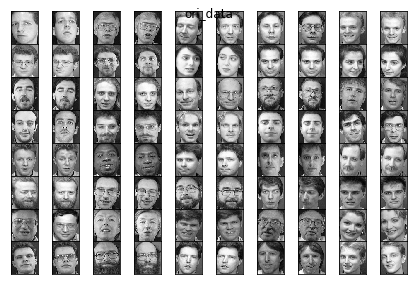

In [13]:
if __name__ == '__main__':
                #功能测试
    a = PCA_data()
    b = PCA_data()
    cov = a.Read_face()
    a.picture_show(cov,'ori_data',3)
    #a.picture_show(cov,'ori_data',4)
  #  res = b.Read_face(dict='face_cov\\')
  #  print('SNR=',a.SNR(cov,res))
    #print(cov)
    #a.Imag_produce(cov)

In [14]:
import numpy as np
from scipy import linalg as la
from sklearn.utils import check_array, as_float_array
from skimage.measure import compare_psnr

class CCIPCA(object):
        
    def __init__(self, n_components=2, amnesic=2.0, copy=True):
        self.n_components = n_components
        if self.n_components < 2:
            raise ValueError ("must specifiy n_components for CCIPCA")
            
        self.copy = copy
        self.amnesic = amnesic
        self.iteration = 0

    def fit(self, X):        
        X = check_array(X)
        n_samples, n_features = X.shape 
        X = as_float_array(X, copy=self.copy)
        
        # init
        if self.iteration == 0:  
            self.mean_ = np.zeros([n_features], np.float)                           #行向量与行向量相加
            self.components_ = np.zeros([self.n_components,n_features], np.float)
        else:
            if n_features != self.components_.shape[1]:
                raise ValueError('The dimensionality of the new data and the existing components_ does not match')   
        
        # incrementally fit the model
        for i in range(0,n_samples):
            self.partial_fit(X[i,:])
        
        # update explained_variance_ratio_
        self.explained_variance_ratio_ = np.sqrt(np.sum(self.components_**2,axis=1))
        
        # sort by explained_variance_ratio_
        idx = np.argsort(-self.explained_variance_ratio_)
        self.explained_variance_ratio_ = self.explained_variance_ratio_[idx]
        self.components_ = self.components_[idx,:]
        
        # re-normalize
        self.explained_variance_ratio_ = (self.explained_variance_ratio_ / self.explained_variance_ratio_.sum())
           
        for r in range(0,self.components_.shape[0]):  #归一化
            self.components_[r,:] /= np.sqrt(np.dot(self.components_[r,:],self.components_[r,:]))
        #self.components_t = np.zeros((40,self.components_.shape[1]))
        return self
        
    def _amnestic(self, t):               # amnestic function
        if t <= int(self.amnesic):
            _rr = float(t+2-1)/float(t+2)    
            _lr = float(1)/float(t+2)    
        else:
            _rr = float(t+2-self.amnesic)/float(t+2)    
            _lr = float(1+self.amnesic)/float(t+2)
        
        return [_rr, _lr]
    

    def partial_fit(self, u):
        n = float(self.iteration)
        V = self.components_
        w1,w2=self._amnestic(n)
        self.mean_ = float(n+1-1)/float(n+1)*self.mean_ + float(1)/float(n+1)*u
        if n != 0:
        # mean center u        
            u = u - self.mean_
    
        # update components

        for j in range(0,self.n_components):
            
            if j > n:
                # the component has already been init to a zerovec
                pass
            
            elif j == n:
                # set the component to u 
                V[j,:] = u
                normedV = V[j,:] / la.norm(V[j,:])
            else:       
                # update the components
                V[j,:] = w1*V[j,:] + w2*np.dot(u,V[j,:])*u / la.norm(V[j,:])
                
                normedV = V[j,:] / la.norm(V[j,:])
            
            u = u - np.dot(np.dot(u.T,normedV),normedV)

        self.iteration += 1
        self.components_ = V
        return
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed

    def predict(self, X):
        decompass_data = np.dot(X, self.components_) + self.mean_
        return decompass_data


(400, 10304)
信噪比： 18.83451773998763
信噪比： 14.790685559031223
信噪比： 16.830368267408915
信噪比： 14.995181101566967
信噪比： 14.76356109557412
信噪比： 15.66914164129156
信噪比： 17.282052673652682
信噪比： 17.088200636943153
信噪比： 16.099774907237013
信噪比： 16.696499065355162
信噪比： 18.952087734041964
信噪比： 19.758955694376038
信噪比： 19.474694693184585
信噪比： 19.740763454571507
信噪比： 19.12442983619507
信噪比： 19.224031084977714
信噪比： 18.658171406065776
信噪比： 19.05791908827006
信噪比： 18.73685166360557
信噪比： 18.83692485392181
信噪比： 20.59842277303069
信噪比： 20.439937487871603
信噪比： 20.189981727066844
信噪比： 20.265294191641864
信噪比： 19.219799882017796
信噪比： 19.561568847769227
信噪比： 19.0123959225737
信噪比： 19.081315330617908
信噪比： 19.301443885052507
信噪比： 19.210975859271183
信噪比： 20.010728877865482
信噪比： 20.32139955392158
信噪比： 19.830768296904683
信噪比： 20.473970580805453
信噪比： 20.211716884706256
信噪比： 18.89758832015408
信噪比： 20.666179447132137
信噪比： 19.863481159335137
信噪比： 20.017800958811854
信噪比： 19.933848161870863
信噪比： 19.475279983482693
信噪比： 19.4129418

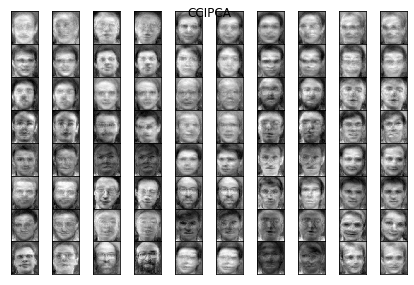

OSError: cannot write mode F as BMP

In [15]:
if __name__ == '__main__':
    a = PCA_data()
    imag_data = a.Read_face()
    print(imag_data.shape)
    b = CCIPCA(40)    
    b.fit(imag_data)

    compass_data = b.transform(imag_data)
    decompass_imag = b.predict(compass_data)
    for i in range(400):
        image = imag_data[i].reshape(112,92)
        reconImage = decompass_imag[i].reshape(112,92)
        print("信噪比：",compare_psnr(image,reconImage,255))
    a.picture_show(decompass_imag,'CCIPCA')
   # print("信噪比：",a.SNR(imag_data,decompass_imag))
    a.Imag_produce(decompass_imag)